## MNIST Dataset Computational Example:

Import Libraries:

In [1]:
import math
import faiss
import struct
import random
import numpy as np
import matplotlib.pyplot as plt
from array import array
from os.path  import join
from collections import Counter
from multiprocessing import Pool
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from concurrent.futures import ThreadPoolExecutor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

MNIST Data Loader Helper Class:

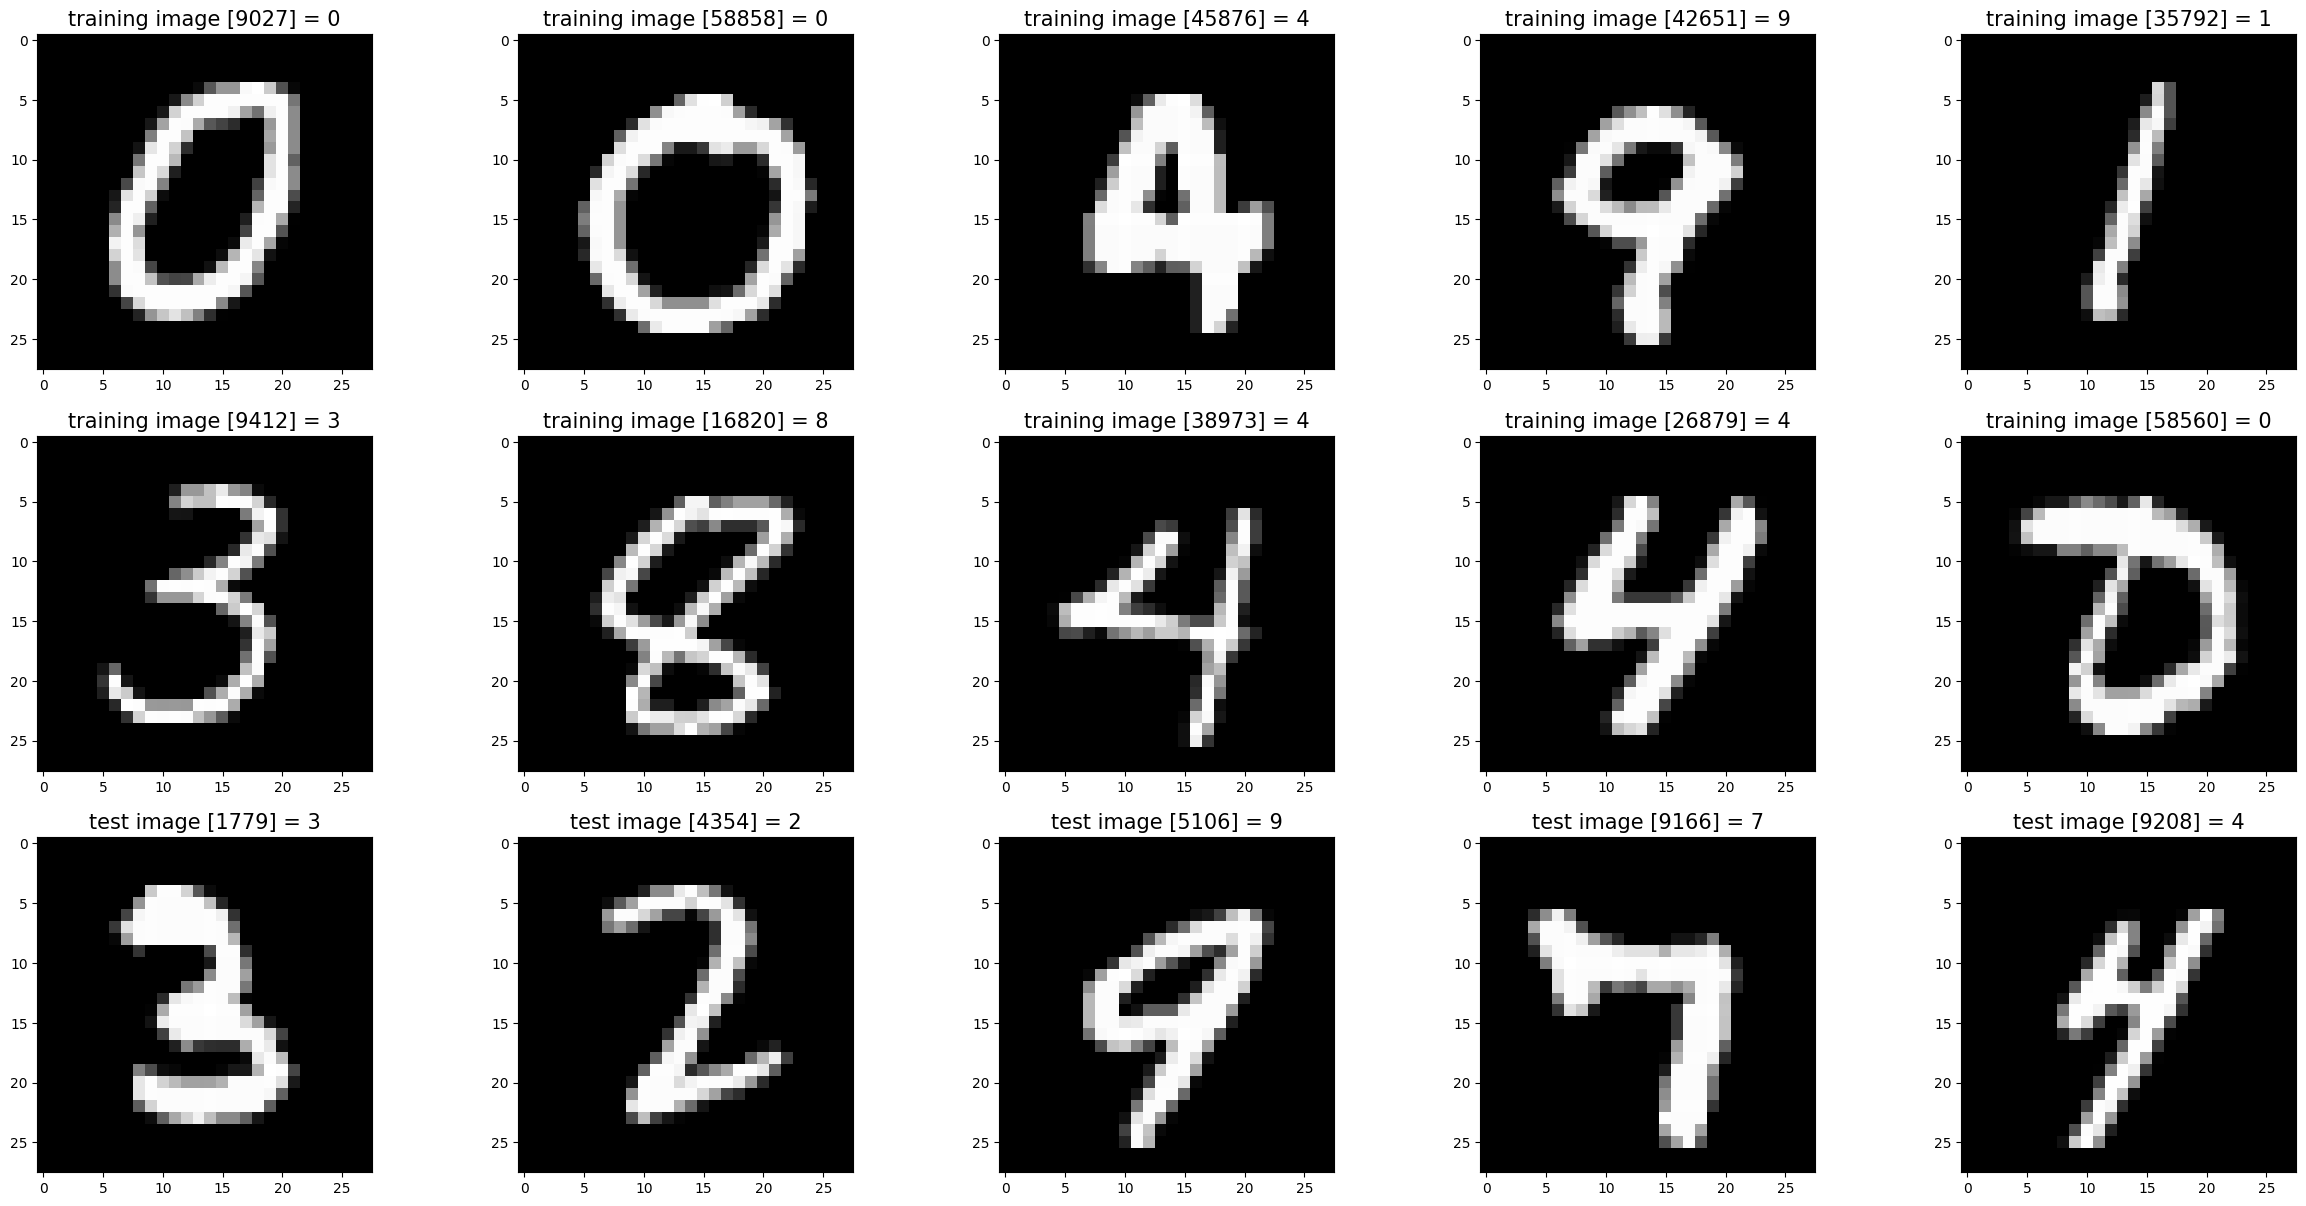

In [2]:
############################
# MNIST Data Loader Class: #
############################
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
    
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

################

########################################
# Set file paths to correct locations: #
########################################
input_path = 'data'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#######################
# Load MINST dataset: #
#######################
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, 
                                   test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

##############################################
# Show some random training and test images: #
##############################################
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

# Show Images: #
################
def show_images(images, title_texts):
    '''Shows a list of images with their related titles'''
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

show_images(images_2_show, titles_2_show)

## Standardize X_n and Visualize Standardized Data:

In [3]:
#####################
# Standardize Data: #
#####################
def standardize(data):
    '''Standardizes our data and returns standardize dataset'''
    std_imgs = []

    for image in data:
        mean = np.mean(image, axis=0)
        std = np.std(image, axis=0)
        std[std == 0] = 1

        std_data = (image-mean)/std
        std_imgs.append(std_data)

    return std_imgs

Xn_train = standardize(x_train)
Xn_test = standardize(x_test)

## Perform FLD and Visualize Reduction:

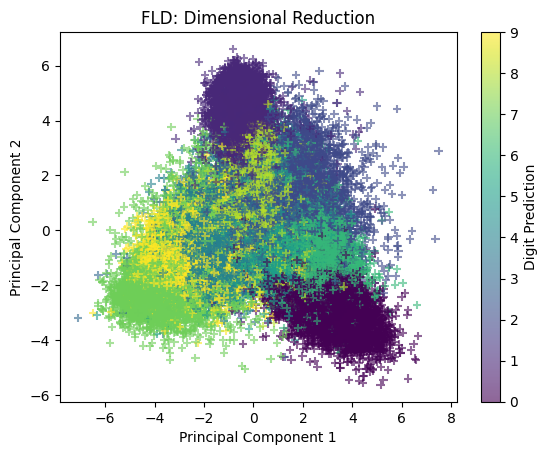

In [4]:
Xn_tr = [np.array(m).flatten() for m in Xn_train]
Xn_te = [np.array(n).flatten() for n in Xn_test]

# We use FLD to reduce a dimension:
FDA = LDA(n_components=2)
Xn_tr_red = FDA.fit_transform(Xn_tr, y_train)
Xn_te_red = FDA.fit_transform(Xn_te, y_test)

# We use PCA to reduce the rest:
pca = PCA(n_components=2)
X_fda = pca.fit_transform(Xn_tr_red)
X_fda_te = pca.fit_transform(Xn_te_red)

'''# Makes a corresponding marker list to denote which number is guessed:
markers = ['$0$','$1$','$2$','$3$','$4$','$5$','$6$','$7$','$8$','$9$']
markerList = []
for i in range(len(y_train)):
    markerList.append(markers[y_train[i]])'''

# Construct the Scatter plot for FLD:
scatter = plt.scatter(X_fda[:, 0], X_fda[:, 1], 
                      c=y_train, alpha=0.6, marker="+")
#for x, y, y_tr, mk in zip(X_pca[:,0], X_pca[:,1], y_train, markerList):
    #plt.plot(x, y, alpha=0.6, marker=mk)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('FLD: Dimensional Reduction')
plt.colorbar(scatter, label='Digit Prediction')
plt.show()

## Perform PCA and Visualize Reduction:

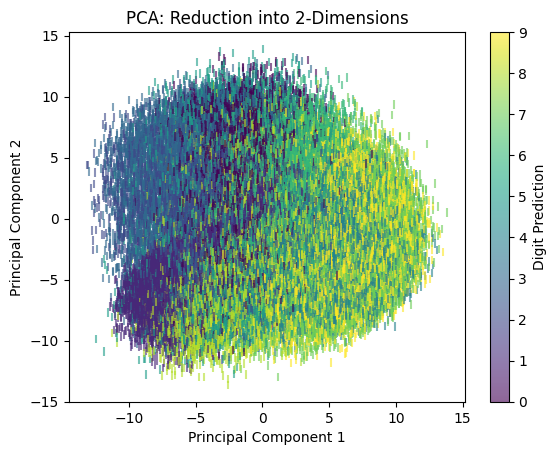

In [5]:
Xn_tr = [np.array(m).flatten() for m in Xn_train]
Xn_te = [np.array(n).flatten() for n in Xn_test]

# This time we do not use any FLD but only PCA:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xn_tr)
X_pca_te = pca.fit_transform(Xn_te)

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                      c=y_train, alpha=0.6, marker="|")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Reduction into 2-Dimensions')
plt.colorbar(scatter, label='Digit Prediction')
plt.show()

## Perform t-SNE and Visualize Reduction:

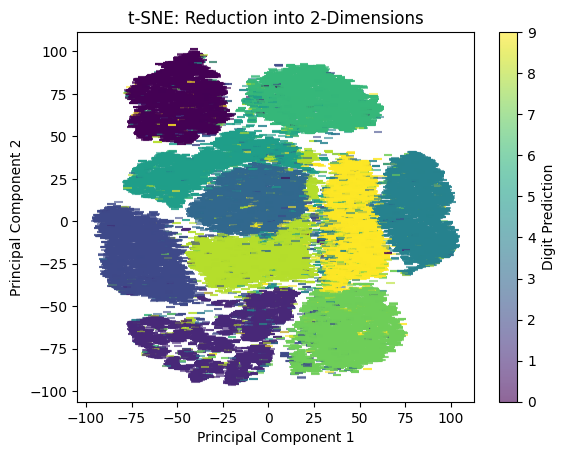

In [6]:
Xn_tr = [np.array(m).flatten() for m in Xn_train]
Xn_te = [np.array(n).flatten() for n in Xn_test]
Xn_tr = np.array(Xn_tr)
Xn_te = np.array(Xn_te)

# This time we only use t-SNE:
tsne = TSNE(n_components=2, n_jobs=-1)
X_tsne = tsne.fit_transform(Xn_tr)
X_tsne_te = tsne.fit_transform(Xn_te)

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                      c=y_train, alpha=0.6, marker="_")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('t-SNE: Reduction into 2-Dimensions')
plt.colorbar(scatter, label='Digit Prediction')
plt.show()

## K-Means Implementation:

## WTA Implementation:

## Hierarchical Agglomerative Clustering Implementation:

## Construct Table and Draw Convergence Curve

In [ ]:
# Construct 4x3 table with k=256,128,64,32:

# Draw the convergence curve for the 3 algorithms using k=32:

## Apply Supervised Methods from Project #1 on X_n, f_X, p_X, and t_X:

In [21]:
def euclidean(x_tei, args):
    '''g function for euclidean distance'''

    # Pass in args and reshape our X vector:
    [N, mus, sig_sh] = args
    gs = [0]*N
    x_tei = np.array(x_tei).reshape(-1,1)

    # Compute Decision Function:
    for n in range(N):
        gs[n] = np.dot((mus[n].transpose()/sig_sh**2),x_tei)
        gs[n] -= np.dot(mus[n].transpose(),mus[n])/(2*sig_sh**2)

    # We find the maximum value for g:
    max_prob = 0
    max_it = 0
    for n in range(N):
        if (gs[n][0][0] > max_prob):
            max_prob = gs[n][0][0]
            max_it = n
    return max_it

def mahalanobis(x_tei, args):
    '''g function for mahalanobis distance'''

    # Pass in args and reshape our X vector:
    [N, mus, mus_t, sig_sh_inv] = args
    gs = [0]*N
    x_tei = np.array(x_tei).reshape(-1,1)

    # Compute Decision Function:
    for n in range(N):
        gs[n] = np.dot(np.dot(mus_t[n],sig_sh_inv.transpose()), x_tei)
        gs[n] -= (1/2)*np.dot(np.dot(mus_t[n],sig_sh_inv),mus[n])
    
    # We find the maximum value for g:
    max_prob = 0
    max_it = 0
    for n in range(N):
        if (gs[n][0][0] > max_prob):
            max_prob = gs[n][0][0]
            max_it = n
    return max_it

def baysian(x_tei, args):
    '''g function for general baysian'''
    [mus, mus_t, sigmas, sigma_invs] = args

    # Set up variables:
    gs = [0]*N
    x_tei = np.array(x_tei).reshape(-1,1)
    x_tt = x_tei.transpose()

    # Compute Decision Function:
    for n in range(N):
        gs[n] = -(1/2)*np.dot(np.dot(x_tt,sigma_invs[n]),x_tei)
        gs[n] += np.dot(np.dot(mus_t[n],sigma_invs[n].transpose()),x_tei)
        gs[n] -= (1/2)*np.dot(np.dot(mus_t[n],sigma_invs[n]),mus[n])
        if np.linalg.det(sigmas[n])!=0:
            gs[n] -= (1/2)*math.log(np.linalg.det(sigmas[n]))
    
    # We find the maximum value for g:
    max_prob = 0
    max_it = 0
    for n in range(N):
        if (gs[n][0][0] > max_prob):
            max_prob = gs[n][0][0]
            max_it = n
    return max_it

class ParaLearn:
    '''Implements three parametric learning models'''

    def calc_acc(self, n_t, g_dec, y_te):
        '''calculates accuracy given a decision vector and test data'''
        acc = []
        for i in range(n_t):
            # Condition for Classification Accuracy:
            if g_dec[i] == y_te[i]:
                acc.append(1)
            else:
                acc.append(0)

        acc = acc.count(1)/n_t
        return acc
        
    def get_params(self, N, x_tr, y_tr):
        '''Gets mu & sigma from the training data
        N -> # of classes
        x_tr -> x training data
        y_tr -> y training data'''
        
        # Finds number of items in each class:
        Ns = []
        for i in range(N):
            Ns.append(y_tr.count(i))

        # Finds vectors of x's for each class:
        Xs = [[]*N for i in range(N)]
        for i in range(len(y_tr)):
            for n in range(N):
                if y_tr[i] == n:
                    arr = np.array([np.array(x_tr[i])])
                    Xs[n].append(arr.reshape(-1, 1))

        # Creates average vectors for each class: 
        mus = []
        for n in range(N):
            if Ns[n] == 0:
                mu = np.array([0 for i in range(N)])
            else:
                mu = np.array([(sum(item[i] for item in Xs[n])/Ns[n]) for i in range(N)])
            mus.append(mu.reshape(-1, 1))
        
        # finds both sigma_i values:
        sigmas = []
        for n in range(N):
            sigmas.append(np.zeros((N,N)))
        
        for n in range(N):
            for i in range(Ns[n]):
                # grabs the difference and dots them
                x_i = np.array(Xs[n][i])

                diff = x_i-mus[n]
                matrix = np.dot(diff, diff.transpose())
           
                # add to running total:
                sigmas[n] = np.add(sigmas[n], matrix)
            sigmas[n] *= (1/(Ns[n]-1))

        return(mus, sigmas)

    def euclidean_fit(self, args):
        '''performs discriminant function w/ min Euclidean distance'''
        # Get arguments from input passed in:
        x_te=args[0]; y_te=args[1]; N=args[2]; mus=args[3]; sigmas=args[4]

        # Define variables necessary to compute g:
        n_t = len(x_te)
        sigma_sh = np.zeros((N,N))
        for i in range(N):
            sigma_sh += sigmas[i]
        sig_sh = math.sqrt(np.linalg.det(sigma_sh))
        
        # Find g values using Euclidean formua:
        g_dec = []
        sub_args = [N, mus, sig_sh]

        for i in range(n_t):
            g_dec.append(euclidean(x_te[i], sub_args))

        # Calculate Accuracy of Algorithm:
        accuracy = ParaLearn.calc_acc(ParaLearn, n_t, g_dec, y_te)
        
        return (accuracy)
    
    def mahalanobis_fit(self, args):
        '''performs discriminant function w/ min Mahalanobis distance'''
        # Get arguments from input passed in:
        x_te=args[0]; y_te=args[1]; N=args[2]; mus=args[3]; sigmas=args[4]
        
        # Define variables necessary to compute g:
        n_t = len(x_te)
        sigma_sh = np.zeros((N,N))
        mus_t = []
        for i in range(N):
            sigma_sh += sigmas[i]
            mus_t.append(mus[i].transpose())
        sig_sh = math.sqrt(np.linalg.det(sigma_sh))

        # Intermediate Calculations:
        if sig_sh != 0:
            sig_sh_inv = np.linalg.inv(sigma_sh)
        else:
            sig_sh_inv = np.zeros((N,N))

        sub_args = [N, mus, mus_t, sig_sh_inv]
        g_dec = []
        for i in range(n_t):
            g_dec.append(mahalanobis(x_te[i],sub_args))
        
        # Calculate Accuracy of Algorithm:
        accuracy = ParaLearn.calc_acc(ParaLearn, n_t, g_dec, y_te)

        return accuracy

    def gen_baysian_fit(self, args):
        '''performs discriminant function w/ gen Baysian decision rule'''
        # Get arguments from input passed in:
        x_te=args[0]; y_te=args[1]; N=args[2]; mus=args[3]; sigmas=args[4]
        
        # Declaring number of items and decision vector:
        n_t = len(x_te)
        g_dec = []

        # Find values necessary to compute g:
        sigma_invs = []
        mus_t = []
        for i in range(N):
            # Check for invertibility and Intermediate Calculations:
            sig_sh = math.sqrt(np.linalg.det(sigmas[i]))
            if sig_sh != 0:
                sigma_invs.append(np.linalg.inv(sigmas[i]))
            else:
                sigma_invs.append(np.ones((N,N)))

            mus_t.append(mus[i].transpose())

        sub_args = [mus, mus_t, sigmas, sigma_invs]
        for i in range(n_t):
            g_dec.append(baysian(x_te[i], sub_args))

        # Calculate Accuracy of Algorithm:
        accuracy = ParaLearn.calc_acc(ParaLearn, n_t, g_dec, y_te)
        return accuracy

###############################
# Apply Euclidean Classifier: #
##########################################
N = len(Xn_tr[0]) # Apply Euclidean fo Xn:
p = ParaLearn.get_params(ParaLearn, N, Xn_tr, y_train)
args = [Xn_te, y_test, N, p[0], p[1]]
euc_acc_Xn = ParaLearn.euclidean_fit(ParaLearn, args)

N = len(X_fda[0]) # Apply Euclidean fo f_X:
p = ParaLearn.get_params(ParaLearn, N, X_fda, y_train)
args = [X_fda_te, y_test, N, p[0], p[1]]
euc_acc_fX = ParaLearn.euclidean_fit(ParaLearn, args)

N = len(X_pca[0]) # Apply Euclidean fo p_X:
p = ParaLearn.get_params(ParaLearn, N, X_pca, y_train)
args = [X_pca_te, y_test, N, p[0], p[1]]
euc_acc_pX = ParaLearn.euclidean_fit(ParaLearn, args)

N = len(X_tsne[0]) # Apply Euclidean fo t_X:
p = ParaLearn.get_params(ParaLearn, N, X_tsne, y_train)
args = [X_tsne_te, y_test, N, p[0], p[1]]
euc_acc_tX = ParaLearn.euclidean_fit(ParaLearn, args)

# Print Output:
print('Euclidean applied to X_n: '+str(euc_acc_Xn))
print('Euclidean applied to f_X: '+str(euc_acc_fX))
print('Euclidean applied to p_X: '+str(euc_acc_pX))
print('Euclidean applied to t_X: '+str(euc_acc_tX))
##################################################################

#################################
# Apply Mahalanobis Classifier: #
############################################
'''N = len(Xn_tr[0]) # Apply Mahalanobis fo Xn:
p = ParaLearn.get_params(ParaLearn, N, Xn_tr, y_train)
args = [Xn_te, y_test, N, p[0], p[1]]
mah_acc_Xn = ParaLearn.mahalanobis_fit(ParaLearn, args)

N = len(X_fda[0]) # Apply Mahalanobis fo f_X:
p = ParaLearn.get_params(ParaLearn, N, X_fda, y_train)
args = [X_fda_te, y_test, N, p[0], p[1]]
mah_acc_fX = ParaLearn.mahalanobis_fit(ParaLearn, args)

N = len(X_pca[0]) # Apply Mahalanobis fo p_X:
p = ParaLearn.get_params(ParaLearn, N, X_pca, y_train)
args = [X_pca_te, y_test, N, p[0], p[1]]
mah_acc_pX = ParaLearn.mahalanobis_fit(ParaLearn, args)

N = len(X_tsne[0]) # Apply Mahalanobis fo t_X:
p = ParaLearn.get_params(ParaLearn, N, X_tsne, y_train)
args = [X_tsne_te, y_test, N, p[0], p[1]]
mah_acc_tX = ParaLearn.mahalanobis_fit(ParaLearn, args)'''

# Print Output:
#print('Mahalanobis applied to X_n: '+str(mah_acc_Xn)) 
#print('Mahalanobis applied to f_X: '+str(mah_acc_fX))
#print('Mahalanobis applied to p_X: '+str(mah_acc_pX)) 
#print('Mahalanobis applied to t_X: '+str(mah_acc_tX))

#############################
# Apply Baysian Classifier: #
############################################
'''N = len(Xn_tr[0]) # Apply Mahalanobis fo Xn:
p = ParaLearn.get_params(ParaLearn, N, Xn_tr, y_train)
args = [Xn_te, y_test, N, p[0], p[1]]
bay_acc_Xn = ParaLearn.gen_baysian_fit(ParaLearn, args)

N = len(X_fda[0]) # Apply Mahalanobis fo f_X:
p = ParaLearn.get_params(ParaLearn, N, X_fda, y_train)
args = [X_fda_te, y_test, N, p[0], p[1]]
bay_acc_fX = ParaLearn.gen_baysian_fit(ParaLearn, args)

N = len(X_pca[0]) # Apply Mahalanobis fo p_X:
p = ParaLearn.get_params(ParaLearn, N, X_pca, y_train)
args = [X_pca_te, y_test, N, p[0], p[1]]
bay_acc_pX = ParaLearn.gen_baysian_fit(ParaLearn, args)

N = len(X_tsne[0]) # Apply Mahalanobis fo t_X:
p = ParaLearn.get_params(ParaLearn, N, X_tsne, y_train)
args = [X_tsne_te, y_test, N, p[0], p[1]]
bay_acc_tX = ParaLearn.gen_baysian_fit(ParaLearn, args)''' 

# Print Output:
#print(bay_acc_Xn)
#print(bay_acc_fX)
#print(bay_acc_pX)
#print(bay_acc_tX)

C:\Users\mathn\AppData\Local\Temp\ipykernel_21624\1069619217.py:11: RuntimeWarning: divide by zero encountered in divide
  gs[n] = np.dot((mus[n].transpose()/sig_sh**2),x_tei)
C:\Users\mathn\AppData\Local\Temp\ipykernel_21624\1069619217.py:12: RuntimeWarning: divide by zero encountered in divide
  gs[n] -= np.dot(mus[n].transpose(),mus[n])/(2*sig_sh**2)
C:\Users\mathn\AppData\Local\Temp\ipykernel_21624\1069619217.py:11: RuntimeWarning: invalid value encountered in divide
  gs[n] = np.dot((mus[n].transpose()/sig_sh**2),x_tei)
C:\Users\mathn\AppData\Local\Temp\ipykernel_21624\1069619217.py:12: RuntimeWarning: invalid value encountered in divide
  gs[n] -= np.dot(mus[n].transpose(),mus[n])/(2*sig_sh**2)


Euclidean applied to X_n: 0.098
Euclidean applied to f_X: 0.2088
Euclidean applied to p_X: 0.173
Euclidean applied to t_X: 0.1673


'N = len(Xn_tr[0]) # Apply Mahalanobis fo Xn:\np = ParaLearn.get_params(ParaLearn, N, Xn_tr, y_train)\nargs = [Xn_te, y_test, N, p[0], p[1]]\nbay_acc_Xn = ParaLearn.gen_baysian_fit(ParaLearn, args)\n\nN = len(X_fda[0]) # Apply Mahalanobis fo f_X:\np = ParaLearn.get_params(ParaLearn, N, X_fda, y_train)\nargs = [X_fda_te, y_test, N, p[0], p[1]]\nbay_acc_fX = ParaLearn.gen_baysian_fit(ParaLearn, args)\n\nN = len(X_pca[0]) # Apply Mahalanobis fo p_X:\np = ParaLearn.get_params(ParaLearn, N, X_pca, y_train)\nargs = [X_pca_te, y_test, N, p[0], p[1]]\nbay_acc_pX = ParaLearn.gen_baysian_fit(ParaLearn, args)\n\nN = len(X_tsne[0]) # Apply Mahalanobis fo t_X:\np = ParaLearn.get_params(ParaLearn, N, X_tsne, y_train)\nargs = [X_tsne_te, y_test, N, p[0], p[1]]\nbay_acc_tX = ParaLearn.gen_baysian_fit(ParaLearn, args)'

## Apply kNN from Project #1 on X_n, f_X, p_X, and t_X

In [9]:
class kNN: 
    '''Applies kNN to X_n, f_X, p_X, and t_X:'''
    def __init__(self, k=3):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def fit_faiss(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = np.array(y)

    def euc_distance(self, a, b):
        return np.linalg.norm(a - b)

    def predict_one(self, x):
        distances = [self.euc_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def predict(self, X):
        with Pool() as pool: # Use multi-cores:
            return pool.map(self.predict_one, X)

    def predict_faiss(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

    def prediction(self, x_tr, x_te, y_tr):
        '''performs prediction of y given x data'''

        # We construct and fill the decision array:
        dec_arr = []

        for tup in x_te:
            # Compute and sort the distances at hand:
            distances = [math.dist(tup, XY) for XY in x_tr]
            k_i = np.argsort(distances)[:self.k]

            # Extract the class of the k nearest neighbor training
            k_nest = [y_tr[i] for i in k_i]
            
            # append the most common class amongst the kNNs
            most_common = np.bincount(k_nest).argmax()
            dec_arr.append(most_common)
        return dec_arr
    
    def results(self, y_pr, y_te):
        '''evaluates classification & classwise accuracy'''
        
        # Define necessary counters & variables:
        acc = []
        n_t = len(y_te)

        for i in range(n_t):
            # Condition for Classification Accuracy:
            if y_pr[i] == y_te[i]:
                acc.append(1)

            else:
                acc.append(0)

        acc = acc.count(1)/n_t

        return acc

#################################################
# DETERMINE WHICH VALUE FOR N_X WORKS THE BEST: #
#################################################
# We need to determine which k works best:

# In prior tests, we found that k=3 works best:
k_val = [i for i in range(3, 4)]
max_acc = 0
accs = []

for i in k_val:
    knn = kNN(k=i)
    knn.fit_faiss(Xn_tr, y_train)
    #dec_arr = knn.predict(Xn_tr, Xn_te, y_train)
    Xn_test = np.array(Xn_te)
    dec_arr = knn.predict_faiss(Xn_test)
    accuracy = knn.results(dec_arr, y_test)
    accs.append(accuracy)

    # compare to see if new value of k works better:
    if (accuracy > max_acc):
        max_k = i
        max_acc = accuracy
        max_accuracy = accuracy

#print(max_k)
print(max_accuracy)

####################
# RUN kNN for f_X: #
####################
knn = kNN(k=max_k)
knn.fit_faiss(X_fda, y_train)
#dec_arr = knn.predict(X_fda, X_fda_te, y_train)
dec_arr = knn.predict_faiss(X_fda_te)
fX_accuracy = knn.results(dec_arr, y_test)
print(fX_accuracy)

####################
# RUN kNN for p_X: #
####################
knn.fit_faiss(X_pca, y_train)
#dec_arr = knn.predict(X_pca, X_pca_te, y_train)
dec_arr = knn.predict_faiss(X_pca_te)
pX_accuracy = knn.results(dec_arr, y_test)
print(pX_accuracy)

####################
# RUN kNN for t_X: #
####################
knn.fit_faiss(X_tsne, y_train)
#dec_arr = knn.predict(X_tsne, X_tsne_te, y_train)
dec_arr = knn.predict_faiss(X_tsne_te)
tX_accuracy = knn.results(dec_arr, y_test)
print(tX_accuracy)


0.9665
0.3144
0.2842
0.6516
